In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));
push!(LOAD_PATH, "src");

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [2]:
#nbx --fname=src/pose.jl
using Colors, Plots
col = palette(:default);
using MyUtils

In [83]:
#nbx
raw"""
    Pose

Encoding the pose of a 2d agent as 
a 2d-position `x` and its head direction `hd`.
"""
struct Pose
    x::Vector{Float64}
    hd::Float64
end;
Pose(x1,x2,hd) = Pose([x1;x2],hd)
Pose() = Pose([0;0], 0)

headdirection(p::Pose) = p.hd
position(p::Pose) = p.x
tuple(p::Pose) = (p.x, p.hd)
MyUtils.angle(p::Pose) = p.hd

Base.iterate(p::Pose) = iterate([p.x, p.hd])
Base.iterate(p::Pose, state::Int) = iterate([p.x, p.hd], state)
Base.getindex(p::Pose, i::Int) = [p.x, p.hd][i]
Base.:(+)(p::Pose, x::Vector{Float64}) = Pose(p.x + x, p.hd)
Base.:(+)(p::Pose, hd::Float64) = Pose(p.x, p.hd + hd)
Base.broadcastable(p::Pose) = [p]

export Pose, headdirection, position, tuple

In [82]:
#nbx
raw"""
    Mat(p::Pose)

Matrix representation of pose `p`. 
Transforms from pose's coordinates to global coordinates
"""
Mat(p::Pose) = [rot(p.hd) p.x; [0 0 1]]

raw"""
    Inv(p::Pose)

Transforms into pose's ``egocentric'' coordinate system.
"""
Inv(p::Pose) = [rot(-p.hd) -rot(-p.hd)*p.x; [0 0 1]]

# Syntactic sugar
Base.:(*)(x::Vector{Float64}, q::Pose) = rot( q.hd)*(x      ) + q.x
Base.:(/)(x::Vector{Float64}, q::Pose) = rot(-q.hd)*(x - q.x)

In [70]:
using LinearAlgebra: I

p = Pose(rand(2), rand()*2π)
x = rand(2)

isapprox(Mat(p)*Inv(p), I(3)),
isapprox(Mat(q)*[x;1], [x*q;1]),
isapprox(Inv(q)*[x;1], [x/q;1])

(true, true, true)

In [71]:
#nbx
raw"""
    p/q

Interprets p and q in global coords and
returns p in q's coordinate system

On pose-matrix level this corresponds to
```
    Inv(q)*Mat(p)
```
"""
function Base.:(/)(p::Pose, q::Pose) 
    x  = rot(-q.hd)*(p.x - q.x)
    hd = p.hd - q.hd
    return Pose(x, hd)
end

raw"""
    p*q

Interprets p as given in q's coords and
returns its allocentric coords.

On pose-matrix level this corresponds to
```
    Mat(q)*Mat(p)
```
"""
function Base.:(*)(p::Pose, q::Pose) 
    x  = rot(q.hd)*(p.x) + q.x
    hd = p.hd + q.hd
    return Pose(x, hd)
end;



In [73]:
p = Pose(rand(2), rand()*2π)
q = Pose(rand(2), rand()*2π)

isapprox(Mat(p/q), Inv(q)*Mat(p), atol=1e-8),
isapprox(Mat(p*q), Mat(q)*Mat(p), atol=1e-8),
isapprox((p/q*q).x , p.x , atol=1e-8),
isapprox((p/q*q).hd, p.hd, atol=1e-8)

(true, true, true, true)

In [84]:
#nbx
function Plots.scatter!(p::Pose; r=1., c=:red, args...)
    x = p.x
    hd = p.hd
    scatter!([x[1]],[x[2]], label=nothing, markerstrokewidth=0.0; c=c, args...)
    plot!([x[1],x[1] + r*cos(hd)], [x[2],x[2] + r*sin(hd)], label=nothing, linecolor=c; args...)
end

function Plots.plot!(p::Pose; r=0.5, n=30, args...)
    x,y = p.x[1], p.x[2]
    hd = p.hd
    θs = range(0, 2π, n)
    plot!(r*sin.(θs) .+ x, r*cos.(θs) .+ y,      label=nothing; args...)
    plot!([x, x + r*cos(hd)],[y, y + r*sin(hd)], label=nothing; args...)
end

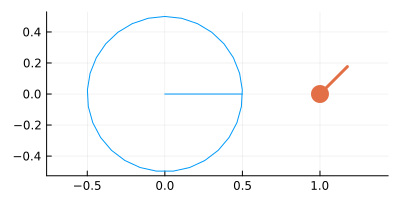

In [79]:
plot(size=(400,200), aspect_ratio=1.0)
plot!(Pose(); linecolor=col[1])
scatter!(Pose([1.0;0.0], π/4); r=0.25, c=col[2], linewidth=3, markersize=10)